## Loading Data

In [6]:
import os
import json
import pandas as pd

def crawl_ducttape_outputs(
    ducttape_output: str,
    results_task: str = "Eval",
    results_json: str = "eval_results",
):
    """Crawl the outputs of ducttape jobs"""
    results_dir = os.path.join(ducttape_output, results_task)
    branches_info = []
    for filename in os.listdir(results_dir):
        # check if its not directory
        filepath = os.path.join(results_dir, filename)
        if os.path.isfile(filepath):
            continue
        
        branches = filename.split("+")
        kwargs = {
            branch.split(".")[0]: branch.split(".")[1] 
            for branch in branches
        }

        branches_info.append((filepath, kwargs))

    num_branches = max(len(i[1]) for i in branches_info)
    results = []
    for filepath, kwargs in branches_info:
        # skip folders with less branches (so we dont repeat on symlinks)
        if len(kwargs) < num_branches:
            continue

        # read results
        with open(os.path.join(filepath, results_json)) as f:
            metrics = json.load(f)
            row = {**kwargs, **metrics}
            results.append(row)

    return pd.DataFrame.from_records(results)

In [7]:
TOWERLLM_OUTS = "/mnt/data/patrick/towerllm-outs/llama2_c4small"
output_df = crawl_ducttape_outputs(TOWERLLM_OUTS)

In [21]:
import yaml

CONFIGS_FOLDER = "../configs/models"
SIZE_CONFIGS = {
    "base": os.path.join(CONFIGS_FOLDER, "llama2_1b.yml"),
    "small1": os.path.join(CONFIGS_FOLDER, "llama2_50m.yml"),
    "small2": os.path.join(CONFIGS_FOLDER, "llama2_150m.yml"),
    "small3": os.path.join(CONFIGS_FOLDER, "llama2_500m.yml"),
}

def get_size(
    hidden_size,
    ffn_hidden_size,
    num_layers,
    num_attention_heads,
    num_kv_heads,
    *args,
    vocab_size=32000,
    return_embeddings=True,
    **kwargs,
):
    embeddings_ps = vocab_size * hidden_size
    grouped_size = hidden_size // (num_attention_heads // num_kv_heads)
    layer_attn_ps = hidden_size * hidden_size * 2  + grouped_size * hidden_size * 2
    layer_ffn_ps = hidden_size * ffn_hidden_size * 3
    layer_ln_ps = hidden_size * 2
    layer_ps = layer_attn_ps + layer_ffn_ps + layer_ln_ps
    decoder_ps = hidden_size * vocab_size 

    total_ps = num_layers * layer_ps 
    if return_embeddings:
        total_ps += embeddings_ps + decoder_ps
    return total_ps

def get_scaling_df(output_df):
    df = output_df.copy()
    def _get_size_from_name(name):
        config_f = SIZE_CONFIGS[name]
        with open(config_f) as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        return get_size(**config, return_embeddings=False)
        
    df["Params"] = df["Size"].apply(_get_size_from_name)
    # order columns to have Size and Params first, and sort by Params
    df = df[["Size", "Params"] + [c for c in df.columns if c not in ["Size", "Params"]]]
    df = df.sort_values("Params")
    return df

In [22]:
scaling_df = get_scaling_df(output_df)
scaling_df

,Size,Params,UseDeepSpeed,loss,ppl,ajusted_ppl,token_ratio
1,small1,23599104,false,10.351727,31311.085578,610037.500848,1.286865
0,small2,189947904,false,10.205917,27062.853808,505668.921248,1.286865
2,small3,455694336,false,10.009663,22240.330929,392811.229007,1.286865


## Compute Scaling Law

In [24]:
import numpy as np
from scipy.optimize import curve_fit

# Define the power law function
def power_law(x, alpha, beta, L):
    return beta * np.power(x, alpha) + L

# Extract the data from the DataFrame
x_data = scaling_df['Params'].values
y_data = scaling_df['loss'].values

# Fit the power law to the data
params, params_covariance = curve_fit(power_law, x_data, y_data)

print("Fitted power law parameters: a =", params[0], ", b =", params[1])

Fitted power law parameters: a = 0.8597176063058344 , b = -1.3352896109622202e-08


/mnt/data/patrick/miniconda3/envs/towerllm-env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


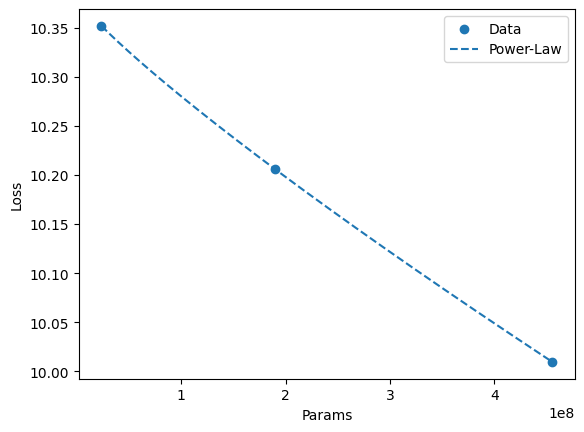

In [27]:
import matplotlib.pyplot as plt

# Generate x values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 1000)

# Compute the y values of the fitted curve
y_fit = power_law(x_fit, *params)

# Plot the original data as scatter plot
plt.scatter(x_data, y_data, color='C0', label='Empirical')

# Plot the fitted curve
plt.plot(x_fit, y_fit, color='C0', linestyle='--', label='Power-Law')

# Add labels and legend
plt.xlabel('Params (Non-Embedding)')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()